# DAT200 CA4 2023

Author: Nora Mikarlsen

Kaggle username: nomik12

### Imports

In [25]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

### Reading data

In [2]:
raw_train = pd.read_csv('data/train.csv')
raw_test = pd.read_csv('data/test.csv')

### Data exploration and visualisation

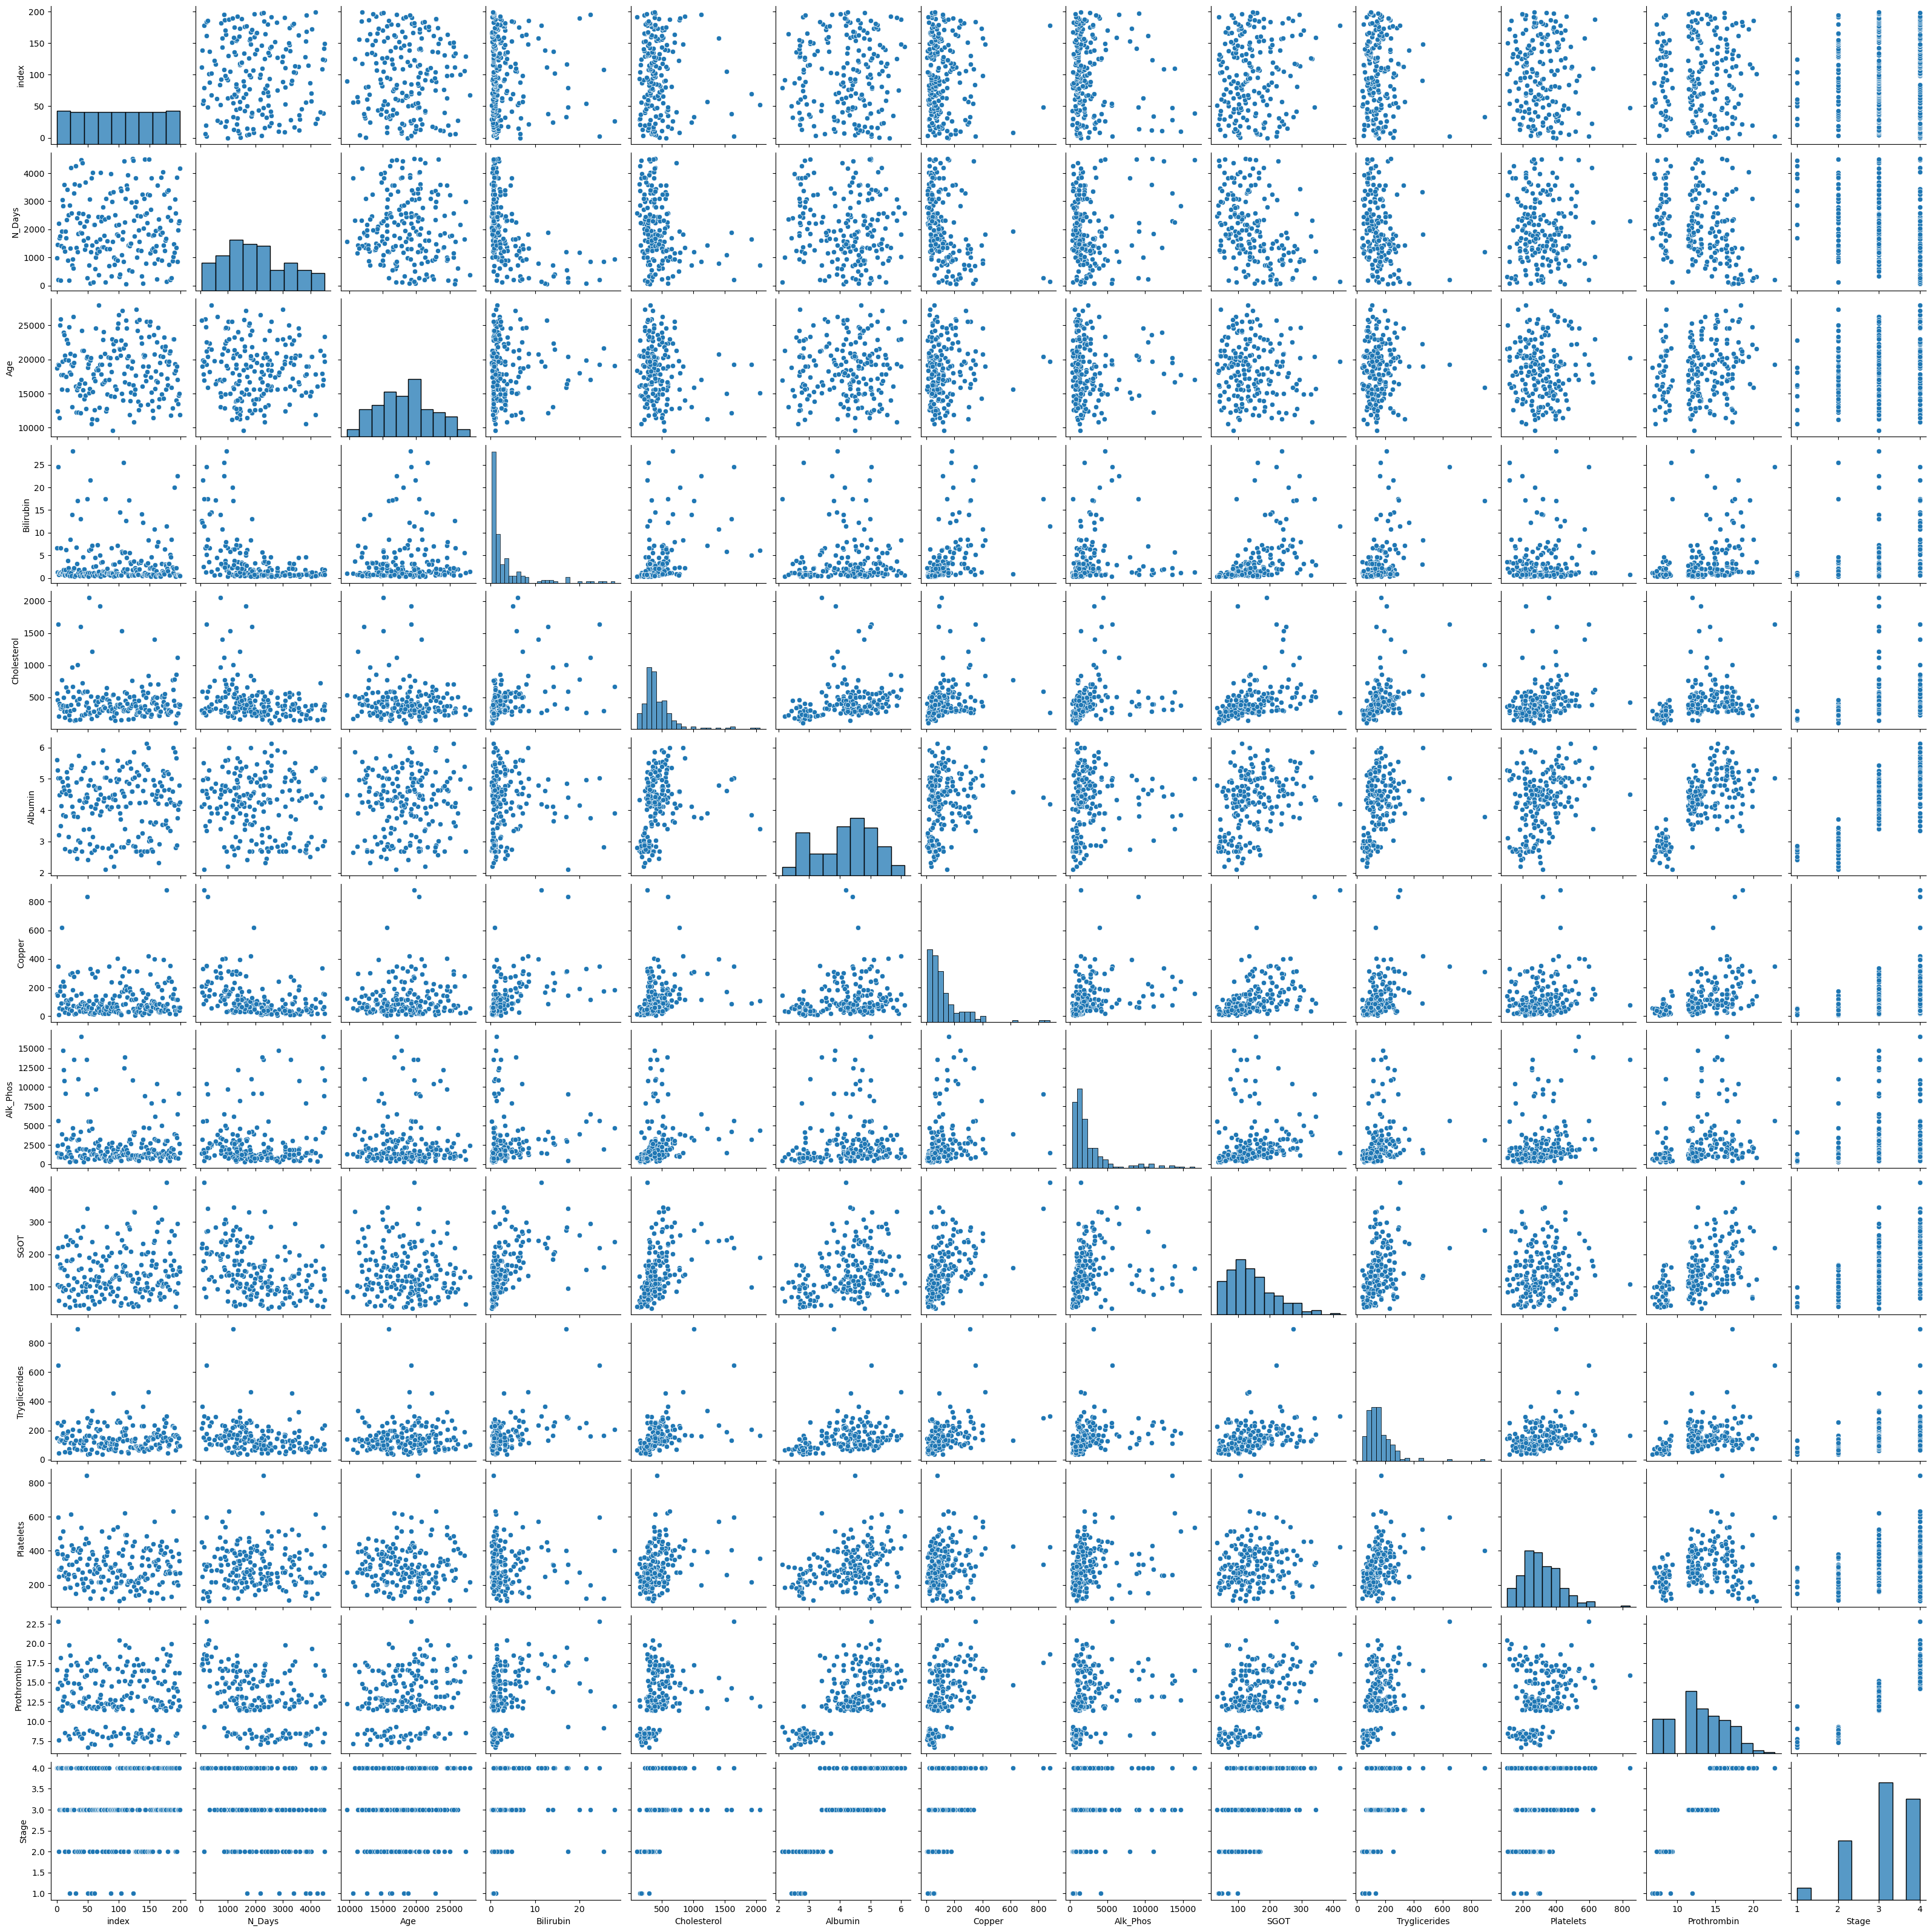

In [3]:
sns.pairplot(raw_train)
plt.show()

From the pairplot we see that there might be some correlation between the features Albumin and Prothrombin, and between Albumin and Stage and Prothrombin and Stage. The heatmap below seem to also support that. 

Another thing to notice is that we have significantly more instances of stages 2, 3 and 4 than of stage 1 in the data. This could be a problem if the machine learning model encounters instances where the true value is 1 in the test data, as it might not have enough data on stage 1 to correctly classsify it. This problem can be overcome by using cross-validation.  

<AxesSubplot: >

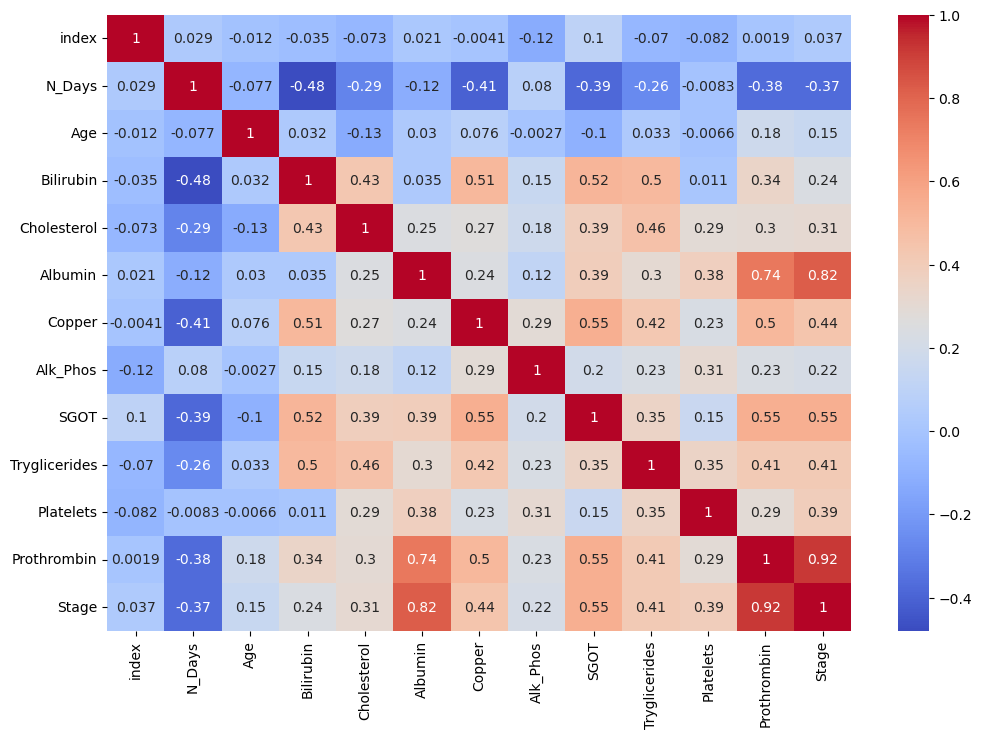

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(raw_train.corr(), annot=True, cmap='coolwarm')

From the heatmap we see that Albumin and Prothrombin are highly correlated with stage. 
Prothrombin is also strongly correlated with Albumin. The pairplot seem to show the same pattern here. 

Some of the others columns show some postive or negative correlation to each other, but none are particularly extreme. 


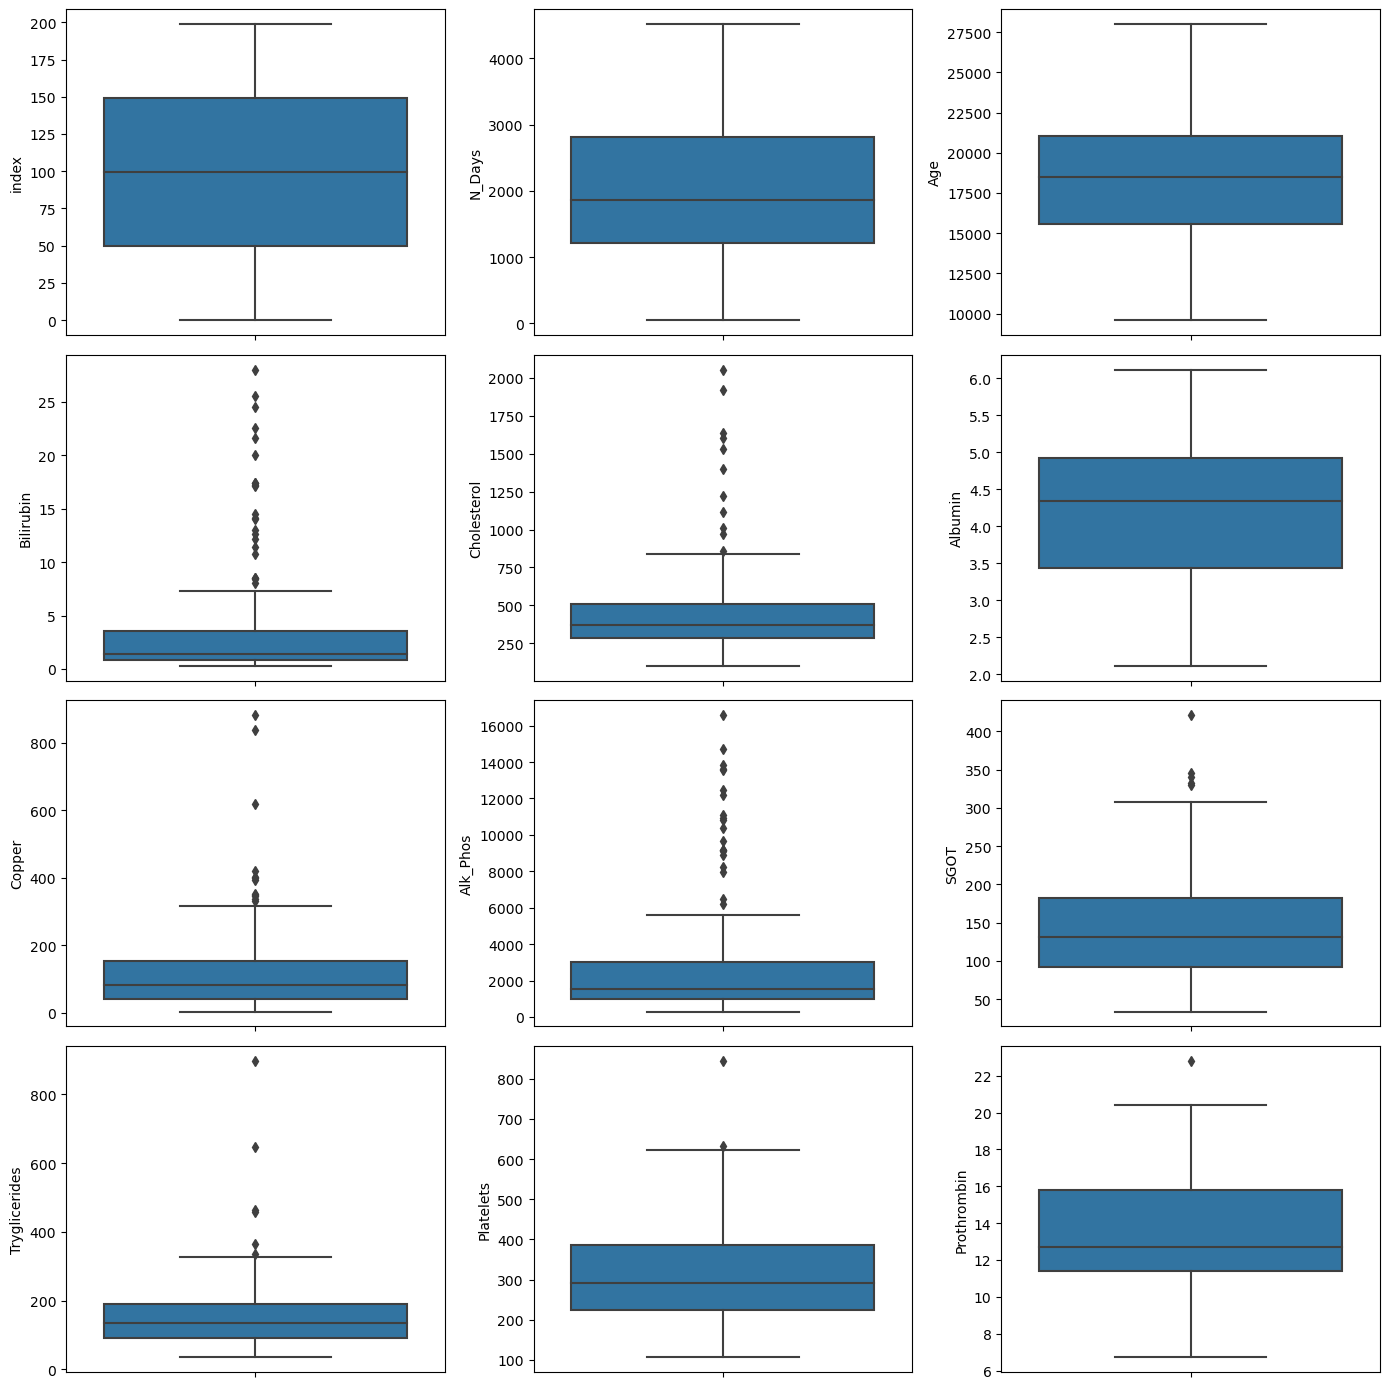

In [5]:
# Boxplots 
fig, axes = plt.subplots(4, 3, figsize=(14,14))
ax = axes.ravel()
# Plot boxplot only for columns with numeric values
for i, col in enumerate(raw_train.select_dtypes(include=np.number).columns[:12]):
    sns.boxplot(data=raw_train, y=col, ax=ax[i])
    plt.tight_layout()
plt.show()

From the boxplot we see that the columns Bilirubin, Cholesterol, Copper, Alk_Phos and Tryglicerides display quite a few outliers.


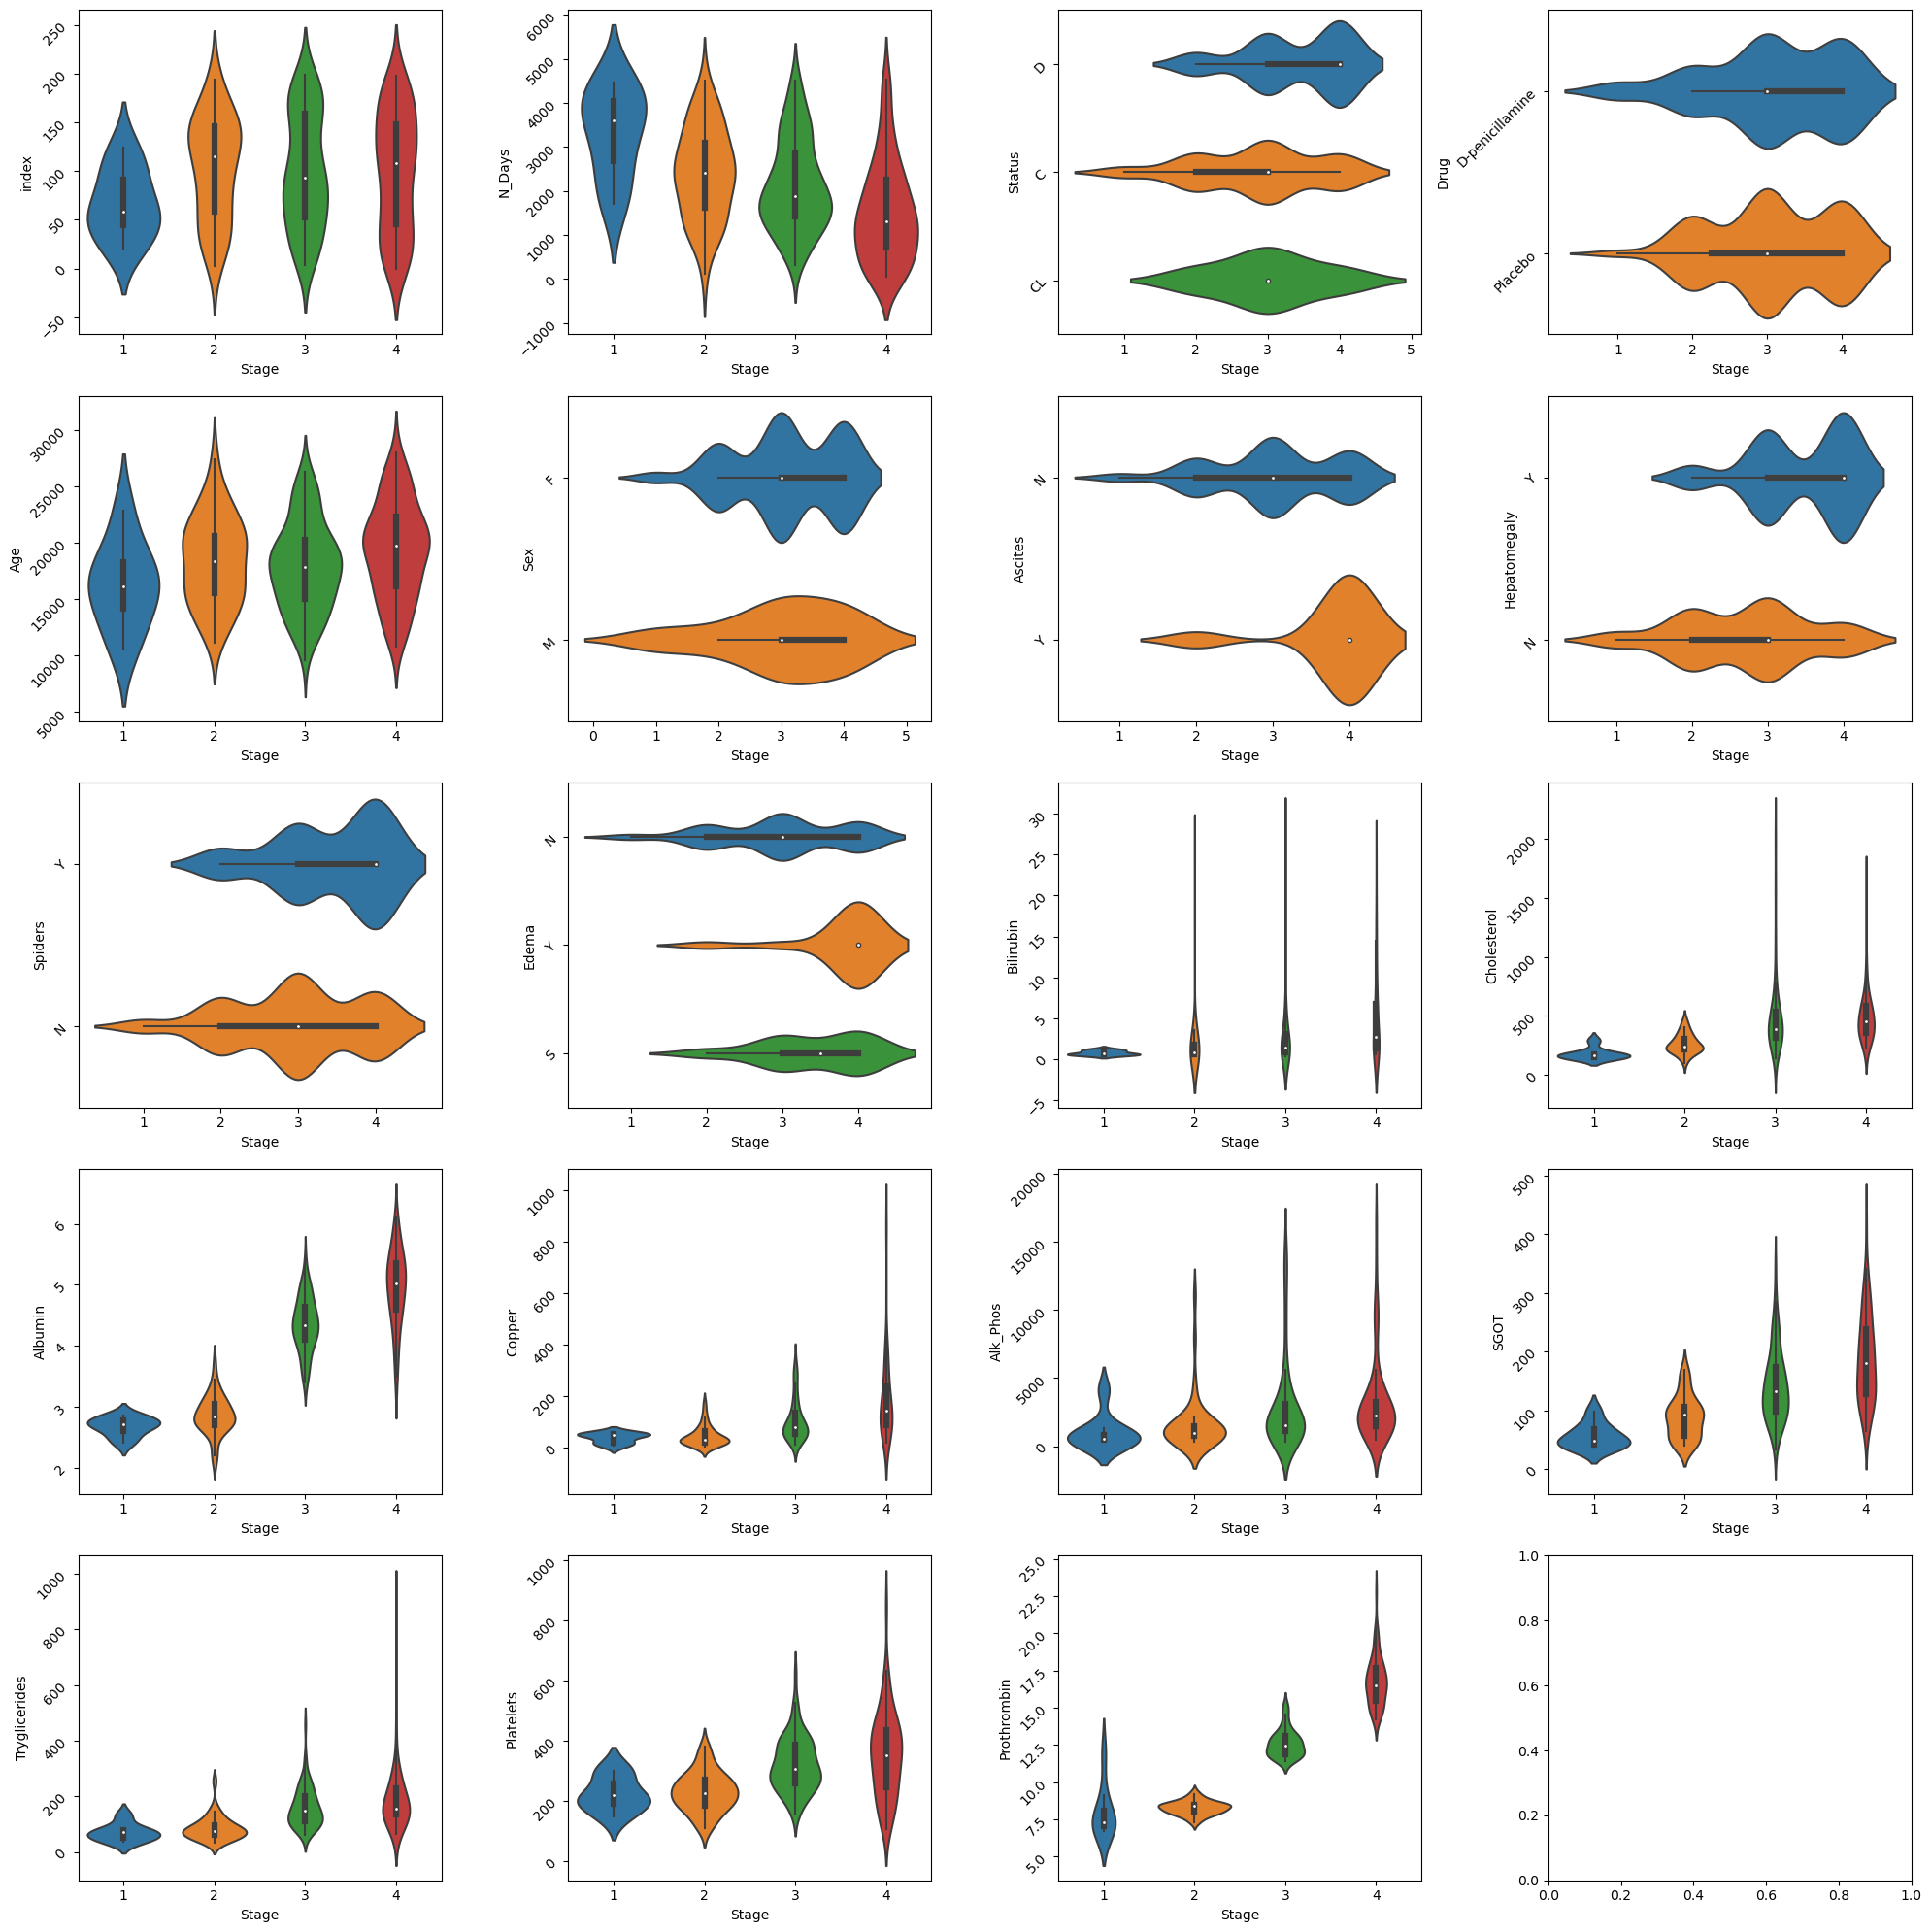

In [6]:
# Violinplots 
fig, axes = plt.subplots(5,4, figsize=(20,20))
ax = axes.ravel()
for i, col in enumerate(raw_train.columns[:19]):
    g = sns.violinplot(data=raw_train, y=col, x='Stage', ax=ax[i])
    g.set_yticklabels(labels=g.get_yticklabels(), rotation=45)
    plt.tight_layout()
plt.show()

The violinplot seems to show the same pattern as the boxplot when it comes to outliers. But here we can also see that the outliers in for example column Copper mostly seem to belong to Stage 4. 

### Data cleaning

__Handle categorical data columns__

In [7]:
# Make dummy columns for categorical values. Drop first column to reduce multi-colinearity of the new dataframe. 
dummy_train = pd.get_dummies(raw_train, drop_first=True)
dummy_test = pd.get_dummies(raw_test, drop_first=True)

__Imputing missing values__

In [8]:
# Impute missing values using the column mean for train dataset
imr = SimpleImputer(missing_values=np.nan, strategy='median')
imr = imr.fit(dummy_train.values)
imputed_data = imr.transform(dummy_train.values)
imputed_train = pd.DataFrame(imputed_data, columns=dummy_train.columns)


In [9]:
# Impute missing values using the column mean for test dataset
imr = SimpleImputer(missing_values=np.nan, strategy='median')
imr = imr.fit(dummy_test.values)
imputed_data = imr.transform(dummy_test.values)
imputed_test = pd.DataFrame(imputed_data, columns=dummy_test.columns)


__Removing outliers__

In [10]:
# Use Z-score for removing outliers 
# code from https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
z = np.abs(stats.zscore(imputed_train))
clean_train = imputed_train[(z < 3).all(axis=1)]

### Data exploration after cleaning

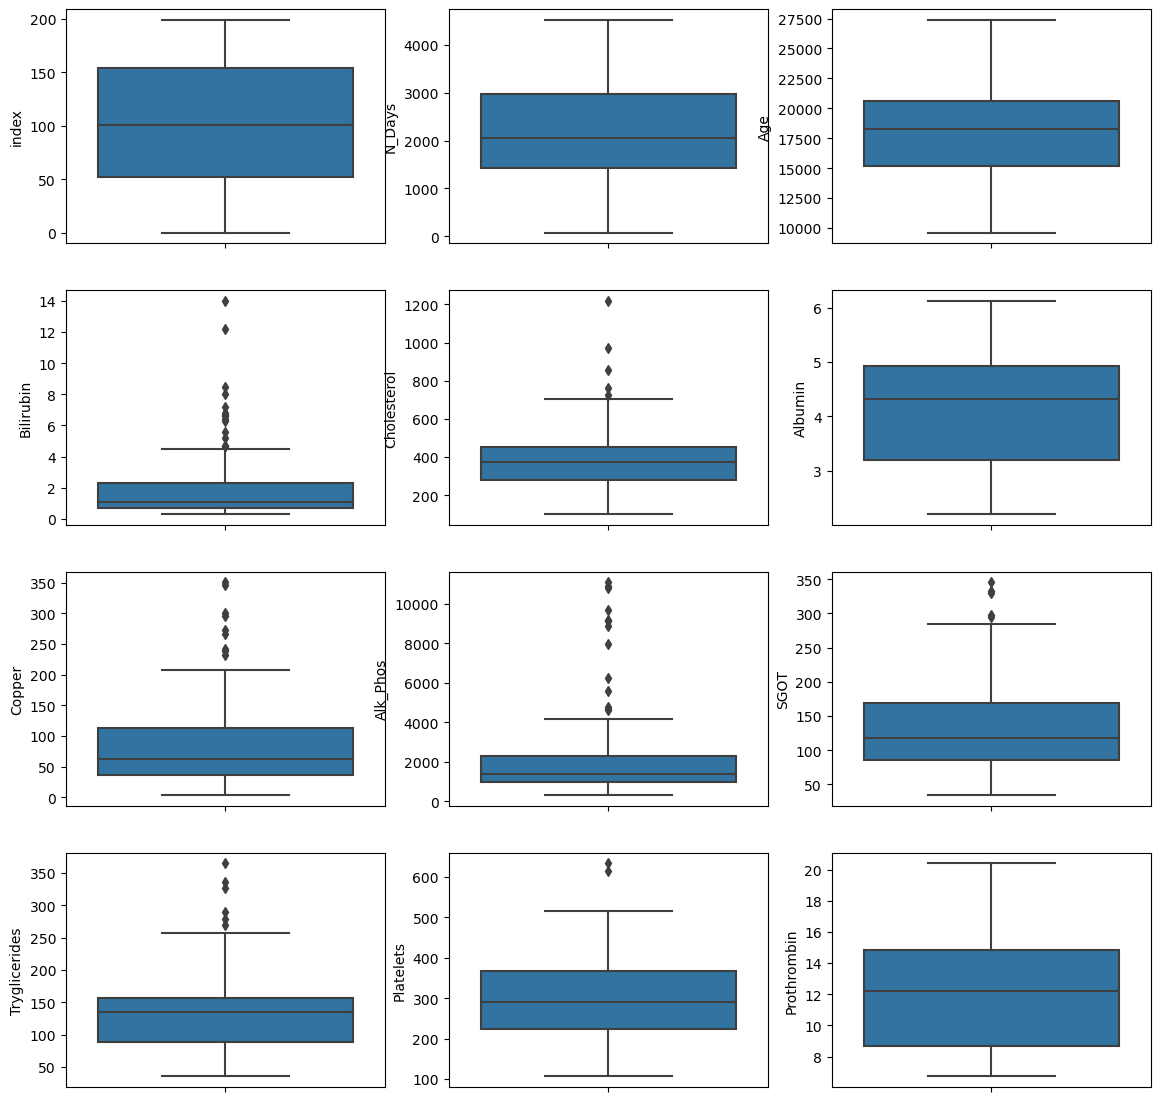

In [11]:
# Boxplots 
fig, axes = plt.subplots(4, 3, figsize=(14,14))
ax = axes.ravel()
# Plot boxplot only for columns with numeric values
for i, col in enumerate(clean_train.select_dtypes(include=np.number).columns[:12]):
    sns.boxplot(data=clean_train, y=col, ax=ax[i])
plt.show()

We see that the most extreme outliers have now been removed from the dataset. If you look at the y-axis of the box plots you can see that many of them have a lower upper limit than they initially had when plotting the box plots.

### Data preprocessing

#### Train test split

In [12]:
X = clean_train.loc[:, clean_train.columns != 'Stage']
y = clean_train['Stage']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1, stratify=y)


#### Scaling

In [13]:
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

### Modelling

#### Data pipeline with kernel

For the SVM pipeline I use the full dataset with the outliers not removed as this seemed to give a better performance. I also add the SimpleImputer to the pipeline so that the strategy parameter can be tuned. 

In [81]:
pipe_svc = make_pipeline(StandardScaler(), SimpleImputer(), LDA(), SVC(random_state=1))


X = dummy_train.loc[:, dummy_train.columns != 'Stage']
y = dummy_train['Stage']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1, stratify=y)
        
# Define ranges for the hyperparameters
param_range  = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # For regularization parameter C.
param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]         # For scaling parameter gamma og rbf-kernel.

param_grid   = [{'svc__C': param_range, 'svc__kernel': ['linear'], 
                 'simpleimputer__strategy': ['mean', 'median', 'most_frequent']},
                {'svc__C': param_range, 'svc__gamma': param_range2, 'svc__kernel': ['rbf'], 
                 'simpleimputer__strategy': ['mean', 'median', 'most_frequent']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8817008917008916
{'simpleimputer__strategy': 'median', 'svc__C': 10.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [82]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))
print('Test f1-macro score: %.3f' % gs.score(X_test, y_test))


Test accuracy: 0.967
Test f1-macro score: 0.929


In [83]:
clf = gs.best_estimator_
clf.fit(X, y)
y_pred_kernel =clf.predict(imputed_test)

sub_df = pd.DataFrame({'index' : [i for i in range(len(y_pred_kernel))], 'Stage': [int(y) for y in y_pred_kernel]})
sub_df.to_csv('submission_kernel.csv', index=False)

This model gives the score 0.97642 on public leaderboard on Kaggle.
This is the model used for the Kaggle submission.

The model gets a significantly higher performance on Kaggle leaderboard than on the cross-validation, so I'm expecting the score to fall a bit on the private leaderboard, but the cross-validation still suggests the model should perform better than BEAT ME. 

#### Data pipeline with regularization

In [14]:
pipe_lr = make_pipeline(StandardScaler(), SimpleImputer(), PCA(), LogisticRegression(random_state=1, max_iter=500))

In [15]:
# Define ranges of parameter values:

X = dummy_train.loc[:, dummy_train.columns != 'Stage']
y = dummy_train['Stage']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1, stratify=y)


param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]        

param_grid   = [{'logisticregression__C': param_range, 'pca__n_components': [i for i in range(1, 22)], 
                'simpleimputer__strategy': ['mean', 'median', 'most_frequent']}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8664285714285714
{'logisticregression__C': 1.0, 'pca__n_components': 17, 'simpleimputer__strategy': 'mean'}


In [16]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))
print('Test f1-macro score: %.3f' % gs.score(X_test, y_test))

Test accuracy: 0.929
Test f1-macro score: 0.710


In [17]:
clf = gs.best_estimator_
clf.fit(X, y)
y_pred_reg =clf.predict(imputed_test)

sub_df = pd.DataFrame({'index' : [i for i in range(len(y_pred_reg))], 'Stage': [int(y) for y in y_pred_reg]})
sub_df.to_csv('submission_reg_pca.csv', index=False)

Score on kaggle: 0.688

#### Other models used for Kaggle submission

I tried other models like Random Forest, but none outperformed the model from *Data pipeline with kernel*, so they are not included in final delivery. 

In [26]:
pipe_rf = make_pipeline(StandardScaler(), SimpleImputer(), LDA(), RandomForestClassifier(random_state=1))


X = dummy_train.loc[:, dummy_train.columns != 'Stage']
y = dummy_train['Stage']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1, stratify=y)
        
# Define ranges for the hyperparameters
param_range  = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # For regularization parameter C.
param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]         # For scaling parameter gamma og rbf-kernel.

param_grid = [{'randomforestclassifier__n_estimators': [i for i in range(50, 250, 10)], 
            'simpleimputer__strategy': ['mean', 'median', 'most_frequent']}]

gs = GridSearchCV(estimator=pipe_rf, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8871953971953971
{'randomforestclassifier__n_estimators': 90, 'simpleimputer__strategy': 'mean'}


In [27]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))
print('Test f1-macro score: %.3f' % gs.score(X_test, y_test))

Test accuracy: 0.967
Test f1-macro score: 0.929


In [28]:
clf = gs.best_estimator_
clf.fit(X, y)
y_pred =clf.predict(imputed_test)

sub_df = pd.DataFrame({'index' : [i for i in range(len(y_pred))], 'Stage': [int(y) for y in y_pred]})
sub_df.to_csv('submission_rf_new.csv', index=False)

### Kaggle submission

For the Kaggle submission I used the model under *datapipeline with kernel* section

Score on public leaderboard on Kaggle: 0.97642